In [1]:
from train import train
from data import initialize_loader, Flickr8k
from encoder_decoder import ResNetEncoder, Decoder
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [3]:
args = AttrDict()
# You can play with the hyperparameters here, but to finish the assignment,
# there is no need to tune the hyperparameters here.
args_dict = {
    "learn_rate": 0.001,
    "batch_size": 128,
    "epochs": 5,
    "log_step": 10,
    "save_step": 70,
    "model_path": "models/",
    "load_model": False,
    "encoder_path": "models/encoder-1-280.ckpt",
    "decoder_path": "models/decoder-1-280.ckpt",
}
args.update(args_dict)

In [4]:
with open("vocab.pkl", 'rb') as f:
        vocab = pickle.load(f)

In [5]:
e = ResNetEncoder(256)
d = Decoder(len(vocab), 256, 512)

In [6]:
train(e, d, args)

cuda
Epoch [0/5], Step [0/291], Loss: 9.0498
Epoch [0/5], Step [10/291], Loss: 6.5164
Epoch [0/5], Step [20/291], Loss: 5.2866
Epoch [0/5], Step [30/291], Loss: 4.9057
Epoch [0/5], Step [40/291], Loss: 4.6415
Epoch [0/5], Step [50/291], Loss: 4.5918
Epoch [0/5], Step [60/291], Loss: 4.5181
Epoch [0/5], Step [70/291], Loss: 4.3418
Epoch [0/5], Step [80/291], Loss: 4.2304
Epoch [0/5], Step [90/291], Loss: 4.0713
Epoch [0/5], Step [100/291], Loss: 3.9409
Epoch [0/5], Step [110/291], Loss: 3.9829
Epoch [0/5], Step [120/291], Loss: 3.9840
Epoch [0/5], Step [130/291], Loss: 3.8433
Epoch [0/5], Step [140/291], Loss: 3.8157
Epoch [0/5], Step [150/291], Loss: 3.7090
Epoch [0/5], Step [160/291], Loss: 3.5718
Epoch [0/5], Step [170/291], Loss: 3.6114
Epoch [0/5], Step [180/291], Loss: 3.7314
Epoch [0/5], Step [190/291], Loss: 3.5437
Epoch [0/5], Step [200/291], Loss: 3.4492
Epoch [0/5], Step [210/291], Loss: 3.4919
Epoch [0/5], Step [220/291], Loss: 3.2592
Epoch [0/5], Step [230/291], Loss: 3.441

In [7]:
transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
            ])

train_data = Flickr8k(csv_file="flickr8k/train.csv", root_dir="flickr8k/images", vocab=vocab, transform=transform)
train_loader = initialize_loader(train_data, batch_size=args.batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<sos> a man is standing on a rock overlooking a lake . <eos>
<sos> a man is standing on top of rocks overlooking the ocean . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


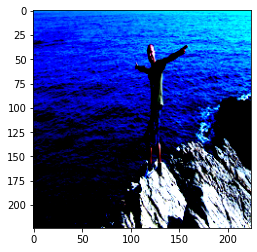

In [15]:
def caption_image(encoderCNN, decoderRNN, image, vocabulary, max_length=50):
    # FROM https://github.com/aladdinpersson/Machine-Learning-Collection/blob/4bd862577ae445852da1c1603ade344d3eb03679/ML/Pytorch/more_advanced/image_captioning/model.py#L49
    # NEED TO CHECK IF IT MAKES SENSE
    result_caption = []

    with torch.no_grad():
        x = encoderCNN(image).unsqueeze(0)
        states = None

        for _ in range(max_length):
            hiddens, states = decoderRNN.lstm(x, states)
            output = decoderRNN.linear(hiddens.squeeze(0))
            predicted = output.argmax(1)
            result_caption.append(predicted.item())
            x = decoderRNN.embedding(predicted).unsqueeze(0)

            if vocabulary.itos[predicted.item()] == "<eos>":
                break

    return [vocabulary.itos[idx] for idx in result_caption]

for i, (imgs, captions, lengths) in enumerate(train_loader):
    imgs = imgs.to(device)
    captions = captions.to(device)
    r = random.randint(0,64)
    img = imgs[r].unsqueeze(0).to(device)
    e.eval()
    d.eval()
    print(" ".join(caption_image(e, d, imgs[r].unsqueeze(0), vocab)))
    plt.imshow(imgs[r].permute(1, 2, 0).cpu())
    sentence = map(lambda x: train_data.vocab.itos[x], captions[r])
    print(" ".join(sentence))
    break